# CONTENT

* ATIS Featurization Facilities
* Feature Importance Measures
* CRF Test

# I. ATIS Data (Spacy-Based Info Augmentation)

### A. Define Info Extraction

In [1]:
import gzip, pickle
import spacy
from spacy.en import English

In [2]:
parser = English()

In [3]:
def extract_info(sent): 
    # assuming parser = spacy.English()
    # sent is a list of words
    if type(sent)==list: sent = ' '.join(sent)
    parsed = parser(unicode(sent))# if type(sent)==str else parser(unicode(sent))
    pos = [token.pos_ for token in parsed]
    ner = ['none' if token.ent_type_=='' else token.ent_type_ for token in parsed]
    dep_rel = [token.dep_ for token in parsed]
    dep_head = [token.head.orth_ for token in parsed]
    return pos, ner, dep_rel, dep_head

### B. Augment Data

In [4]:
path = "/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/LUIS/DATA/"

In [5]:
f = gzip.open(path+'atis.fold0.pkl.gz','rb')
train, valid, test, dicts = pickle.load(f)

In [6]:
train[0][0]

array([554, 194, 268,  64,  62,  16,   8, 234, 481,  20,  40,  58, 234,
       415, 205], dtype=int32)

In [7]:
dicts.keys() # 'tables2idx' is not used, since it's not derivable generally (atis-specific info)

['labels2idx', 'tables2idx', 'words2idx']

In [8]:
i2w = {i:w for w,i in dicts['words2idx'].iteritems()}
i2l = {i:l for l,i in dicts['labels2idx'].iteritems()}

In [9]:
print map(i2w.get, train[0][0])

['what', 'flights', 'leave', 'atlanta', 'at', 'about', 'DIGIT', 'in', 'the', 'afternoon', 'and', 'arrive', 'in', 'san', 'francisco']


In [10]:
X_train = [map(i2w.get, encoded_sent) for encoded_sent in train[0]]
X_test = [map(i2w.get, encoded_sent) for encoded_sent in test[0]]

In [11]:
print X_train[0]
print X_test[0]

['what', 'flights', 'leave', 'atlanta', 'at', 'about', 'DIGIT', 'in', 'the', 'afternoon', 'and', 'arrive', 'in', 'san', 'francisco']
['i', 'would', 'like', 'to', 'find', 'a', 'flight', 'from', 'charlotte', 'to', 'las', 'vegas', 'that', 'makes', 'a', 'stop', 'in', 'st.', 'louis']


In [12]:
Y_train = [map(i2l.get, encoded_labels) for encoded_labels in train[2]]
Y_test = [map(i2l.get, encoded_sent) for encoded_sent in test[2]]

In [13]:
print Y_train[0]
print Y_test[0]

['O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-depart_time.time_relative', 'B-depart_time.time', 'O', 'O', 'B-depart_time.period_of_day', 'O', 'O', 'O', 'B-toloc.city_name', 'I-toloc.city_name']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-stoploc.city_name']


In [14]:
len(dicts['labels2idx'].keys()) # 127 labels in total

127

In [15]:
def augment_info(sent): 
    # sent: a list of words.
    # return: (words, pos, ner, dep_rel, dep_head).
    pos, ner, dep_rel, dep_head = extract_info(sent)
    return (sent, pos, ner, dep_rel, dep_head)

In [16]:
print augment_info(X_train[0])

(['what', 'flights', 'leave', 'atlanta', 'at', 'about', 'DIGIT', 'in', 'the', 'afternoon', 'and', 'arrive', 'in', 'san', 'francisco'], [u'ADJ', u'NOUN', u'VERB', u'ADV', u'ADP', u'ADP', u'PROPN', u'ADP', u'DET', u'NOUN', u'CONJ', u'VERB', u'ADP', u'PROPN', u'NOUN'], ['none', 'none', 'none', 'none', 'none', 'none', u'ORG', 'none', 'none', u'TIME', 'none', 'none', 'none', 'none', 'none'], [u'det', u'nsubj', u'ROOT', u'advmod', u'prep', u'nmod', u'pobj', u'prep', u'det', u'pobj', u'cc', u'conj', u'prep', u'compound', u'pobj'], [u'flights', u'leave', u'leave', u'at', u'leave', u'DIGIT', u'at', u'DIGIT', u'afternoon', u'in', u'leave', u'leave', u'arrive', u'francisco', u'in'])


In [17]:
X_train_augmented = [augment_info(sent) for sent in X_train]
X_test_augmented = [augment_info(sent) for sent in X_test]

In [18]:
for entry in X_train_augmented[0]:
    print entry

['what', 'flights', 'leave', 'atlanta', 'at', 'about', 'DIGIT', 'in', 'the', 'afternoon', 'and', 'arrive', 'in', 'san', 'francisco']
[u'ADJ', u'NOUN', u'VERB', u'ADV', u'ADP', u'ADP', u'PROPN', u'ADP', u'DET', u'NOUN', u'CONJ', u'VERB', u'ADP', u'PROPN', u'NOUN']
['none', 'none', 'none', 'none', 'none', 'none', u'ORG', 'none', 'none', u'TIME', 'none', 'none', 'none', 'none', 'none']
[u'det', u'nsubj', u'ROOT', u'advmod', u'prep', u'nmod', u'pobj', u'prep', u'det', u'pobj', u'cc', u'conj', u'prep', u'compound', u'pobj']
[u'flights', u'leave', u'leave', u'at', u'leave', u'DIGIT', u'at', u'DIGIT', u'afternoon', u'in', u'leave', u'leave', u'arrive', u'francisco', u'in']


# Featurize

In [19]:
from pyparsing import StringEnd, oneOf, FollowedBy, Optional, ZeroOrMore, SkipTo

In [20]:
prefix = ['anti','de','dis','en','em','fore','in','im','il','ir',
          'inter','mid','mis','non','over','pre','re','semi','sub',
          'super','trans','un','under']
suffix = ['able','ible','al','ial','ed','en','er','est','ful','ic',
          'ing','ion','tion','ation','ition','ity','ty','ive','ative',
          'itive','less','ly','ment','ness','ous','eous','ious','s',
          'es','y','ism']

In [36]:
class Featurize:
    
    def __init__(self, prefix=[], suffix=[]): # lists of pfx/sfx.
        self.prefix = prefix
        self.suffix = suffix
        end_of_string = StringEnd()
        pfx_pyp_regex = oneOf(' '.join(prefix))
        sfx_pyp_regex = oneOf(' '.join(suffix)) + FollowedBy(end_of_string)
        self.template = (ZeroOrMore(pfx_pyp_regex)('prefix') +
                         SkipTo(sfx_pyp_regex | end_of_string)('root') + 
                         Optional(sfx_pyp_regex)('suffix'))              
        self.afx = lambda word: self.template.parseString(word)
        self.feat_set = {'pfx': lambda w_idx,datum: self.afx(datum[0][w_idx]).prefix[0] \
                                     if self.afx(datum[0][w_idx]).prefix!='' else 'no_pfx',
                         'sfx': lambda w_idx,datum: self.afx(datum[0][w_idx]).suffix[0] \
                                     if self.afx(datum[0][w_idx]).suffix!='' else 'no_sfx',
                         'root': lambda w_idx,datum: self.afx(datum[0][w_idx]).root}
#                          'isdigit': lambda w_idx,datum: datum[0][w_idx].isdigit(),
#                          'pos': lambda w_idx,datum: datum[1][w_idx],
#                          'ner': lambda w_idx,datum: datum[2][w_idx],
#                          'dep_rel': lambda w_idx,datum: datum[3][w_idx],
#                          'dep_head': lambda w_idx,datum: datum[4][w_idx]} 
            # datum: (words, pos, ner, dep_rel, dep_head)
        
    def word_featurize(self, datum, i): 
        # datum: (sent, pos, ner, dep_rel, dep_head).
        # i: index of the token processed. 
        features = []
        for feat in self.feat_set.keys():
            features.append(feat+'='+str(self.feat_set[feat](i,datum)))
        if i > 0:
            for feat in self.feat_set.keys():
                features.append('-1'+feat+'='+str(self.feat_set[feat](i-1,datum)))
                if i > 1:
                    features.append('-2'+feat+'='+str(self.feat_set[feat](i-2,datum)))
        else: features.append('BOS')
        if i < len(datum[0])-1:
            for feat in self.feat_set.keys():
                features.append('+1'+feat+'='+str(str(self.feat_set[feat](i+1,datum))))
                if i < len(datum[0])-2:
                    features.append('+2'+feat+'='+str(str(self.feat_set[feat](i+2,datum))))
        else: features.append('EOS')    
        
        return features
        
    def sent_featurize(self, datum):
        # datum: (sent, pos, ner, dep_rel, dep_head).   
        return [self.word_featurize(datum, i) for i in xrange(len(datum[0]))] 

In [22]:
featurizer = Featurize(prefix,suffix)

In [23]:
test_sent = X_train_augmented[0]
print test_sent

(['what', 'flights', 'leave', 'atlanta', 'at', 'about', 'DIGIT', 'in', 'the', 'afternoon', 'and', 'arrive', 'in', 'san', 'francisco'], [u'ADJ', u'NOUN', u'VERB', u'ADV', u'ADP', u'ADP', u'PROPN', u'ADP', u'DET', u'NOUN', u'CONJ', u'VERB', u'ADP', u'PROPN', u'NOUN'], ['none', 'none', 'none', 'none', 'none', 'none', u'ORG', 'none', 'none', u'TIME', 'none', 'none', 'none', 'none', 'none'], [u'det', u'nsubj', u'ROOT', u'advmod', u'prep', u'nmod', u'pobj', u'prep', u'det', u'pobj', u'cc', u'conj', u'prep', u'compound', u'pobj'], [u'flights', u'leave', u'leave', u'at', u'leave', u'DIGIT', u'at', u'DIGIT', u'afternoon', u'in', u'leave', u'leave', u'arrive', u'francisco', u'in'])


In [24]:
print featurizer.word_featurize(test_sent,1)

['dep_rel=nsubj', 'ner=none', 'dep_head=leave', 'sfx=s', 'isdigit=False', 'pfx=no_pfx', 'root=flight', 'pos=NOUN', '-1dep_rel=det', '-1ner=none', '-1dep_head=flights', '-1sfx=no_sfx', '-1isdigit=False', '-1pfx=no_pfx', '-1root=what', '-1pos=ADJ', '+1dep_rel=ROOT', '+2dep_rel=advmod', '+1ner=none', '+2ner=none', '+1dep_head=leave', '+2dep_head=at', '+1sfx=no_sfx', '+2sfx=no_sfx', '+1isdigit=False', '+2isdigit=False', '+1pfx=no_pfx', '+2pfx=no_pfx', '+1root=leave', '+2root=atlanta', '+1pos=VERB', '+2pos=ADV']


In [25]:
print featurizer.sent_featurize(test_sent)[0]

['dep_rel=det', 'ner=none', 'dep_head=flights', 'sfx=no_sfx', 'isdigit=False', 'pfx=no_pfx', 'root=what', 'pos=ADJ', 'BOS', '+1dep_rel=nsubj', '+2dep_rel=ROOT', '+1ner=none', '+2ner=none', '+1dep_head=leave', '+2dep_head=leave', '+1sfx=s', '+2sfx=no_sfx', '+1isdigit=False', '+2isdigit=False', '+1pfx=no_pfx', '+2pfx=no_pfx', '+1root=flight', '+2root=leave', '+1pos=NOUN', '+2pos=VERB']


In [26]:
train = [(x_augmented,y) for x_augmented,y in zip(X_train_augmented,Y_train)]
test = [(x_augmented,y) for x_augmented,y in zip(X_test_augmented,Y_test)]

In [27]:
print train[0][0]
print 
print train[0][1]

(['what', 'flights', 'leave', 'atlanta', 'at', 'about', 'DIGIT', 'in', 'the', 'afternoon', 'and', 'arrive', 'in', 'san', 'francisco'], [u'ADJ', u'NOUN', u'VERB', u'ADV', u'ADP', u'ADP', u'PROPN', u'ADP', u'DET', u'NOUN', u'CONJ', u'VERB', u'ADP', u'PROPN', u'NOUN'], ['none', 'none', 'none', 'none', 'none', 'none', u'ORG', 'none', 'none', u'TIME', 'none', 'none', 'none', 'none', 'none'], [u'det', u'nsubj', u'ROOT', u'advmod', u'prep', u'nmod', u'pobj', u'prep', u'det', u'pobj', u'cc', u'conj', u'prep', u'compound', u'pobj'], [u'flights', u'leave', u'leave', u'at', u'leave', u'DIGIT', u'at', u'DIGIT', u'afternoon', u'in', u'leave', u'leave', u'arrive', u'francisco', u'in'])

['O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-depart_time.time_relative', 'B-depart_time.time', 'O', 'O', 'B-depart_time.period_of_day', 'O', 'O', 'O', 'B-toloc.city_name', 'I-toloc.city_name']


# II. Feature Importance Measure

### A. A Datum Before Featurization

In [37]:
sample = train[0][0]
for entry in sample:
    print entry
    print
print type(sample), ',', len(sample)

['what', 'flights', 'leave', 'atlanta', 'at', 'about', 'DIGIT', 'in', 'the', 'afternoon', 'and', 'arrive', 'in', 'san', 'francisco']

[u'ADJ', u'NOUN', u'VERB', u'ADV', u'ADP', u'ADP', u'PROPN', u'ADP', u'DET', u'NOUN', u'CONJ', u'VERB', u'ADP', u'PROPN', u'NOUN']

['none', 'none', 'none', 'none', 'none', 'none', u'ORG', 'none', 'none', u'TIME', 'none', 'none', 'none', 'none', 'none']

[u'det', u'nsubj', u'ROOT', u'advmod', u'prep', u'nmod', u'pobj', u'prep', u'det', u'pobj', u'cc', u'conj', u'prep', u'compound', u'pobj']

[u'flights', u'leave', u'leave', u'at', u'leave', u'DIGIT', u'at', u'DIGIT', u'afternoon', u'in', u'leave', u'leave', u'arrive', u'francisco', u'in']

<type 'tuple'> , 5


### B. Start with Prefix, Suffix, Root

In [38]:
ft = Featurize(prefix, suffix)
featurized_sample = ft.sent_featurize(sample)

In [39]:
print featurized_sample[0] # feature set of word at position 0.

['pfx=no_pfx', 'root=what', 'sfx=no_sfx', 'BOS', '+1pfx=no_pfx', '+2pfx=no_pfx', '+1root=flight', '+2root=leave', '+1sfx=s', '+2sfx=no_sfx']


##### Feature Selection Facilities

In [ ]:
prefix = ['anti','de','dis','en','em','fore','in','im','il','ir',
          'inter','mid','mis','non','over','pre','re','semi','sub',
          'super','trans','un','under']
suffix = ['able','ible','al','ial','ed','en','er','est','ful','ic',
          'ing','ion','tion','ation','ition','ity','ty','ive','ative',
          'itive','less','ly','ment','ness','ous','eous','ious','s',
          'es','y','ism']

In [308]:
class FeatureExtractor:
    
    def __init__(self, prefix=[], suffix=[]): # lists of pfx/sfx.
        self.prefix = prefix
        self.suffix = suffix
        end_of_string = StringEnd()
        pfx_pyp_regex = oneOf(' '.join(prefix))
        sfx_pyp_regex = oneOf(' '.join(suffix)) + FollowedBy(end_of_string)
        self.template = (ZeroOrMore(pfx_pyp_regex)('prefix') +
                         SkipTo(sfx_pyp_regex | end_of_string)('root') + 
                         Optional(sfx_pyp_regex)('suffix'))              
        self.afx = lambda word: self.template.parseString(word)
        self.feat_set = {'pfx': lambda w_idx,datum: self.afx(datum[0][w_idx]).prefix[0] \
                                     if self.afx(datum[0][w_idx]).prefix!='' else 'no_pfx',
                         'sfx': lambda w_idx,datum: self.afx(datum[0][w_idx]).suffix[0] \
                                     if self.afx(datum[0][w_idx]).suffix!='' else 'no_sfx',
                         'root': lambda w_idx,datum: self.afx(datum[0][w_idx]).root,
                         'word': lambda w_idx,datum: datum[0][w_idx],
                         'pos': lambda w_idx,datum: datum[1][w_idx],
                         'ner': lambda w_idx,datum: datum[2][w_idx],
                         'dep_rel': lambda w_idx,datum: datum[3][w_idx],
                         'dep_head': lambda w_idx,datum: datum[4][w_idx]} 
            # datum: (words, pos, ner, dep_rel, dep_head)
        
    def get_feature(self, w_idx, (datum,labels), feature='pfx'):
        return (labels[w_idx], self.feat_set[feature](w_idx, datum))


In [120]:
ft_ex = FeatureExtractor(prefix, suffix)

In [126]:
entry = train[0]
print entry # entry: (datum, labels)

((['what', 'flights', 'leave', 'atlanta', 'at', 'about', 'DIGIT', 'in', 'the', 'afternoon', 'and', 'arrive', 'in', 'san', 'francisco'], [u'ADJ', u'NOUN', u'VERB', u'ADV', u'ADP', u'ADP', u'PROPN', u'ADP', u'DET', u'NOUN', u'CONJ', u'VERB', u'ADP', u'PROPN', u'NOUN'], ['none', 'none', 'none', 'none', 'none', 'none', u'ORG', 'none', 'none', u'TIME', 'none', 'none', 'none', 'none', 'none'], [u'det', u'nsubj', u'ROOT', u'advmod', u'prep', u'nmod', u'pobj', u'prep', u'det', u'pobj', u'cc', u'conj', u'prep', u'compound', u'pobj'], [u'flights', u'leave', u'leave', u'at', u'leave', u'DIGIT', u'at', u'DIGIT', u'afternoon', u'in', u'leave', u'leave', u'arrive', u'francisco', u'in']), ['O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-depart_time.time_relative', 'B-depart_time.time', 'O', 'O', 'B-depart_time.period_of_day', 'O', 'O', 'O', 'B-toloc.city_name', 'I-toloc.city_name'])


In [127]:
ft_ex.get_feature(3, entry)

('B-fromloc.city_name', 'no_pfx')

In [175]:
ft_ex.get_feature(3, entry, feature='sfx')

('B-fromloc.city_name', 'no_sfx')

##### Prefix

In [209]:
%%time
label_pfx_pairs = []
for (datum,labels) in train:
    for w_idx in xrange(len(datum[0])): # datum[0]: list of words.
        label_pfx_pairs.append(ft_ex.get_feature(w_idx,(datum,labels),feature='pfx'))

CPU times: user 6.71 s, sys: 51.7 ms, total: 6.76 s
Wall time: 6.76 s


In [210]:
label_pfx_pairs[:10]

[('O', 'no_pfx'),
 ('O', 'no_pfx'),
 ('O', 'no_pfx'),
 ('B-fromloc.city_name', 'no_pfx'),
 ('O', 'no_pfx'),
 ('B-depart_time.time_relative', 'no_pfx'),
 ('B-depart_time.time', 'no_pfx'),
 ('O', 'in'),
 ('O', 'no_pfx'),
 ('B-depart_time.period_of_day', 'no_pfx')]

In [211]:
pfx_set = prefix + ['no_pfx']
label_set = list({label for label,pfx in label_pfx_pairs})

In [212]:
print len(label_set), ',', len(pfx_set)

118 , 24


In [213]:
import numpy as np

In [214]:
p2i = {p:i for i,p in enumerate(pfx_set)}
l2i = {l:i for i,l in enumerate(label_set)}

In [215]:
label_pfx_matrix = np.zeros((len(label_set),len(pfx_set)))

In [216]:
label_pfx_matrix.shape

(118, 24)

In [217]:
for label,pfx in label_pfx_pairs:
    label_pfx_matrix[l2i[label]][p2i[pfx]] += 1

In [218]:
total_freq = label_pfx_matrix.sum()
print total_freq

45266.0


In [219]:
from __future__ import division

In [250]:
def pr_pfx(pfx):
    return label_pfx_matrix[:,p2i[pfx]].sum() / total_freq

def pr_pfx_given_label(pfx, label):
    return label_pfx_matrix[l2i[label]][p2i[pfx]] / \
            label_pfx_matrix[l2i[label],:].sum()

log = lambda x: np.log(x) if x!=0 else np.log(1e-20)
div = lambda num,denom: 0. if denom==0. else num/denom
    
def sps_pfx(label):
    return sum(pr_pfx_given_label(pfx,label)*log(div(pr_pfx_given_label(pfx,label),pr_pfx(pfx)))
               for pfx in pfx_set)

In [251]:
pr_pfx('no_pfx')

0.94558830026951801

In [252]:
pr_pfx_given_label('no_pfx','O')

0.96015384082325628

In [253]:
sps_pfx('O')

0.022105621426489527

In [254]:
sum(sps_pfx(label) for label in label_set)

17.780485633947862

##### Write It In General Form

In [299]:
# DATA
print train[0]
print len(train)

((['what', 'flights', 'leave', 'atlanta', 'at', 'about', 'DIGIT', 'in', 'the', 'afternoon', 'and', 'arrive', 'in', 'san', 'francisco'], [u'ADJ', u'NOUN', u'VERB', u'ADV', u'ADP', u'ADP', u'PROPN', u'ADP', u'DET', u'NOUN', u'CONJ', u'VERB', u'ADP', u'PROPN', u'NOUN'], ['none', 'none', 'none', 'none', 'none', 'none', u'ORG', 'none', 'none', u'TIME', 'none', 'none', 'none', 'none', 'none'], [u'det', u'nsubj', u'ROOT', u'advmod', u'prep', u'nmod', u'pobj', u'prep', u'det', u'pobj', u'cc', u'conj', u'prep', u'compound', u'pobj'], [u'flights', u'leave', u'leave', u'at', u'leave', u'DIGIT', u'at', u'DIGIT', u'afternoon', u'in', u'leave', u'leave', u'arrive', u'francisco', u'in']), ['O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-depart_time.time_relative', 'B-depart_time.time', 'O', 'O', 'B-depart_time.period_of_day', 'O', 'O', 'O', 'B-toloc.city_name', 'I-toloc.city_name'])
3983


In [300]:
import numpy as np
from __future__ import division

In [310]:
def selectional_strength(data, feature):
    
    ft_ex = FeatureExtractor(prefix, suffix)
    
    label_feat_pairs = []
    for (datum,labels) in data:
        for w_idx in xrange(len(datum[0])):
            label_feat_pairs.append(ft_ex.get_feature(w_idx,(datum,labels),feature=feature))
    
    feat_set = list({feat for label,feat in label_feat_pairs})
    label_set = list({label for label,feat in label_feat_pairs})
    
    f2i = {f:i for i,f in enumerate(feat_set)}
    l2i = {l:i for i,l in enumerate(label_set)}
    
    label_feat_matrix = np.zeros((len(label_set),len(feat_set)))
    for label,feat in label_feat_pairs:
        label_feat_matrix[l2i[label]][f2i[feat]] += 1
    
    total_freq = label_feat_matrix.sum()
    
    log = lambda x: np.log(x) if x!=0 else np.log(1e-20)
    div = lambda num,denom: 0. if denom==0. else num/denom
    
    def pr_feat(feat):
        return label_feat_matrix[:,f2i[feat]].sum() / total_freq

    def pr_feat_given_label(feat, label):
        return label_feat_matrix[l2i[label]][f2i[feat]] / \
                label_feat_matrix[l2i[label],:].sum()

    def sps_feat(label):
        return sum(pr_feat_given_label(feat,label)*log(div(pr_feat_given_label(feat,label),pr_feat(feat)))
                   for feat in feat_set)
    
    return sum(sps_feat(label) for label in label_set)
    

In [311]:
features = ['pfx','sfx','root','word','pos','ner','dep_rel','dep_head']

In [315]:
%%time
for feature in features:
    print "Selectional Preference Strength of %s: %.6f" % (feature, selectional_strength(train, feature))

Selectional Preference Strength of pfx: 17.780486
Selectional Preference Strength of sfx: 133.128422
Selectional Preference Strength of root: 639.749198
Selectional Preference Strength of word: 657.157284
Selectional Preference Strength of pos: 168.285976
Selectional Preference Strength of ner: 89.761791
Selectional Preference Strength of dep_rel: 208.981067
Selectional Preference Strength of dep_head: 419.078054
CPU times: user 24.1 s, sys: 167 ms, total: 24.2 s
Wall time: 24.2 s


In [316]:
sps = [17.780486, 133.128422, 639.749198, 657.157284, 168.285976, 89.761791, 208.981067, 419.078054]
accuracies = [0.623831, 0.717547, 0.959665, 0.960426, 0.759948, 0.643944, 0.835616, 0.767123]

In [317]:
from scipy.stats.stats import pearsonr

In [319]:
print "Pearson Correlation: %.6f | p-value: %.6f" % pearsonr(sps, accuracies)

Pearson Correlation: 0.916254 | p-value: 0.001378


In [323]:
import matplotlib.pyplot as plt
%matplotlib inline

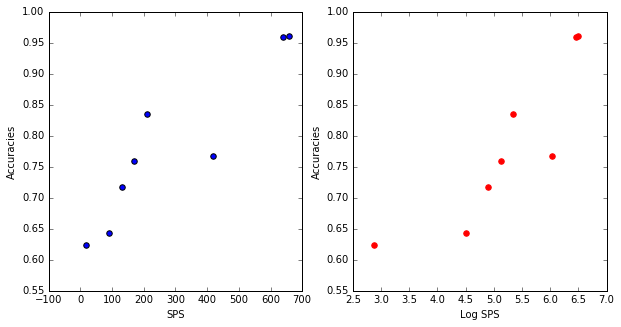

In [339]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(121)
ax.scatter(sps, accuracies, s=30)
ax.set_xlabel('SPS')
ax.set_ylabel('Accuracies')
ax = plt.subplot(122)
ax.scatter(np.log(sps), accuracies, s=30, color='red')
ax.set_xlabel('Log SPS')
ax.set_ylabel('Accuracies')
plt.show()

# III. CRF (L-BFGS)

In [28]:
from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
import pycrfsuite
import os, cPickle, time

In [29]:
class CRF:
    
    def __init__(self, train, test, verbose=0, # train/test format: ((words,pos,ner,dep_rel,dep_head),labels).
                 config={'c1': 1.0, # coef for L1.
                         'c2': 1e-3, # coef for L2.
                         'max_iterations': 100,
                         'feature.possible_transitions':True}, # include unseen transitions.
                 tagger_name='crf.crfsuite', # name of generated tagger.
                 featurizer=Featurize(),
                 save_featurized=False, # save featurized data.
                 save_path=os.getcwd()):
        print "... featurizing data"
        self.featurizer = featurizer
        self.X_train = [self.featurizer.sent_featurize(datum[0]) for datum in train]
        self.Y_train = [datum[1] for datum in train]
        self.X_test = [self.featurizer.sent_featurize(datum[0]) for datum in test]
        self.Y_test = [datum[1] for datum in test]
        if save_featurized:
            cPickle.dump((self.X_train,self.Y_train,self.X_test,self.Y_test),
                         open(save_path+time.ctime()+'data.p','wb')) # avoid overwriting data saved.
        crf = pycrfsuite.Trainer(verbose=verbose)
        print "... loading data into CRF"
        for x,y in zip(self.X_train, self.Y_train):
            crf.append(x,y)
        crf.set_params(config)
        print "... training"
        crf.train(tagger_name)
        self.tagger = pycrfsuite.Tagger()
        self.tagger.open(tagger_name)
    
    def tag(self, sent): # takes a sentence as a string.
        sent = sent.split()
        sent = augment_info(sent) # (words,pos,ner,dep_rel,dep_head), which featurizer takes.
        tags = self.tagger.tag(self.featurizer.sent_featurize(sent))
        return zip(sent, tags)
    
    def evaluate(self):
        y_true = self.Y_test
        y_pred = [self.tagger.tag(sent) for sent in self.X_test]
        lb = LabelBinarizer()
        y_true_in_tags = lb.fit_transform(list(chain.from_iterable(y_true))) # get a list of tags in 1-hot.
        y_pred_in_tags = lb.transform(list(chain.from_iterable(y_pred)))
        tagset = list(set(lb.classes_))
        class_indices = {cls:idx for idx,cls in enumerate(lb.classes_)}
        print classification_report(
            y_true_in_tags,
            y_pred_in_tags,
            labels = [class_indices[cls] for cls in tagset],
            target_names = tagset
        )
        

In [30]:
%%time
atis_crf = CRF(train, test, featurizer=Featurize(prefix,suffix), 
               save_featurized=True,save_path='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/LUIS/DATA/')

... featurizing data
... loading data into CRF
... training
CPU times: user 5min 14s, sys: 1.38 s, total: 5min 15s
Wall time: 5min 15s


In [38]:
atis_crf.evaluate()

                              precision    recall  f1-score   support

B-depart_date.today_relative       0.89      0.89      0.89         9
 B-arrive_date.date_relative       0.00      0.00      0.00         2
 B-depart_date.date_relative       0.77      1.00      0.87        17
          I-restriction_code       1.00      0.33      0.50         3
      B-depart_date.day_name       0.95      0.99      0.97       212
      I-arrive_time.end_time       0.75      0.75      0.75         8
      B-fromloc.airport_code       1.00      0.40      0.57         5
             B-cost_relative       1.00      0.97      0.99        37
                   B-connect       1.00      1.00      1.00         6
             B-flight_number       0.85      1.00      0.92        11
 B-depart_time.time_relative       0.91      0.97      0.94        65
           I-toloc.city_name       0.92      0.98      0.95       265
 B-arrive_time.period_of_day       0.57      0.67      0.62         6
 B-depart_time.peri

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
y_true = atis_crf.Y_test
y_pred = [atis_crf.tagger.tag(sent) for sent in atis_crf.X_test]

In [34]:
print y_true[0]
print y_pred[0]

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-stoploc.city_name']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-stoploc.city_name']


In [35]:
from itertools import chain

In [36]:
y_true_merged = list(chain.from_iterable(y_true))
y_pred_merged = list(chain.from_iterable(y_pred))

In [37]:
print "Accuracy: %.2f" % accuracy_score(y_true_merged,y_pred_merged)

Accuracy: 0.96
